In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import datetime
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords
import prepare
import wrangle 
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## Initial Planning Analysis

In [2]:
# # read in primary utterances csv for dataframe
# df = pd.read_csv('./utterances.csv')
# df.head()

In [3]:
# # find utterance count per episode
# df.episode.value_counts()

In [4]:
# # find utterance count per episode
# test = df.episode.value_counts() < 2
# test.sum()

In [5]:
# # pull in episodes df
# ep_df = pd.read_csv('./episodes.csv')
# ep_df.head()

In [6]:
# # check episode content to see if it matches episode id
# df[df.episode == 92554].utterance.to_list()

In [7]:
# # check ep_df.id = df.episode
# ep_df[ep_df.id == 92554].title.to_list()

### Initial takeaways
There are episodes with one utterance, showing less interview setting and more reporting.

ep_df.id == df.episode

### Acquire


In [8]:
# df = pd.read_csv('./utterances.csv')
# ep_df = pd.read_csv('./episodes.csv')


In [9]:
# df['speaker'] = df.speaker.str.lower()
# df['program'] = df.program.str.lower()
# df['title'] = df.title.str.lower()

In [10]:
# # joining utterances df ('df') and episodes on 'id'
# joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
# joined_df.drop(columns = ['id'], inplace=True)
# joined_df.rename(columns={'episode':'episode_id'}, inplace = True)

In [11]:
# joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')

In [12]:
# df = acquire.get_df()

In [13]:
# df['speaker'] = df.speaker.str.replace(r'\([^)]*\)','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'host','', regex=True)
# df['speaker'] = df.speaker.str.replace(r'[^a-z0-9\s\.]','', regex=True).str.strip()
# df['speaker'] = df.speaker.str.replace('lourdes','lulu')

In [14]:
# host_map = pd.read_json('host-map.json')
# host_map = host_map.T
# hosts = host_map.name.to_list()
# hosts.append('neal conan')

In [15]:
# df['is_host'] = df.speaker.isin(hosts)

In [16]:
# df

## Preparation

- nulls
- duplicates
- create sentiment score
- use prep functions
- keep some punctuation
- split
- date to datetime

In [17]:

# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()
# # create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']
# # drop duplicates
# df.drop_duplicates(inplace = True)
# # drop nulls
# df.dropna(inplace=True)
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)
# # vader sentiment analysis
# sia = nltk.sentiment.SentimentIntensityAnalyzer()
# df['vader'] = df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# # date column to datetime
# df['date'] = pd.to_datetime(df.episode_date)
# # cutoff dates prior to 2005 due to low observation count
# df = df[df.date > '2005']
# # double check drop nulls
# df.dropna(inplace = True)

In [18]:
# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()


In [19]:
# create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]

In [20]:
# # drop nulls
# df.dropna(inplace=True)

In [21]:
# drop duplicates
# df.drop_duplicates(inplace = True)

In [22]:
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']

In [23]:
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']


In [24]:
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]


In [25]:
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)


In [26]:
# df.head()

In [27]:
# df = wrangle.get_npr_data()

## JOSH
- Are there words that are said more frequently by hosts? By time of day? By category?
What host(s) say(s) the most words?

In [28]:
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [29]:
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [30]:
# df['lemmatized'] = df.lemmatized.astype(str)
# df['clean'] = df.clean.astype(str)

In [31]:
df = df.astype({'clean':str,'lemmatized':str})

In [32]:
df['message_length'] = df.clean.apply(len)
df['word_count'] = df.clean.apply(basic_clean).apply(str.split).apply(len)

In [33]:
train, validate, test = wrangle.split_data(df)

In [34]:
df[df.is_host == True].speaker.value_counts().index.to_list()

['neal conan',
 'ira flatow',
 'steve inskeep',
 'robert siegel',
 'melissa block',
 'renee montagne',
 'farai chideya',
 'scott simon',
 'rachel martin',
 'david greene',
 'michele norris',
 'audie cornish',
 'ari shapiro',
 'flora lichtman',
 'tony cox',
 'don gonyea',
 'linda wertheimer',
 'noel king',
 'allison aubrey',
 'deborah amos',
 'tom goldman',
 'mary louise kelly',
 'jackie northam',
 'john ydstie',
 'eric westervelt',
 'brian naylor',
 'guy raz',
 'carrie kahn',
 'joe palca',
 'adam davidson',
 'andrea seabrook',
 'tamara keith',
 'robert smith',
 'jennifer ludden',
 'gwen thompkins',
 'daniel zwerdling',
 'kelly mcevers',
 'laura sullivan',
 'mike pesca',
 'debbie elliott',
 'howard berkes',
 'cheryl corley',
 'lynn neary',
 'kenneth turan',
 'wade goodwyn',
 'richard gonzales',
 'madeleine brand',
 'd',
 'karen grigsby bates',
 'liane hansen',
 'susan stamberg',
 'alan cheuse',
 'ed gordon',
 'noah adams',
 'michel martin',
 'ailsa chang',
 'anthony brooks',
 'rebecca r

### Hosts

In [35]:
# df of hosts
host_df = df[df.is_host==True]
# hosts with most interviews
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

In [36]:
# aggregate utterances by the speakers that are in top 10 hosts
host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['clean'].agg(lambda col: ' '.join(col))

In [37]:
def string_cleaning(s):
    '''
    Function to remove punctuation and numbers from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z'\s]", '', s)

    return s

In [82]:
more_stopwords = pd.read_excel('stop_words_df.xlsx')
more_stopwords = more_stopwords.words.to_list()
# more_stopwords.append(['us','let','go','get','today','yeah','yes','no'])

In [83]:
host_words = host_words.apply(string_cleaning).apply(remove_stopwords, extra_words = more_stopwords)

In [84]:
# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan'].split()).value_counts()

In [85]:
# create word counts dataframe of all host word frequencies
word_counts = pd.concat([conan_freq, flatow_freq, inskeep_freq, siegel_freq, block_freq, montagne_freq, chideya_freq, simon_freq, martin_freq, greene_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['conan', 'flatow', 'inskeep', 'siegel', 'block', 'montagne', 'chideya', 'simon', 'martin', 'greene']
word_counts

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
talk,18268,3861,934,553,807,451,997,420,536,589
let,13896,3366,1617,623,619,545,1542,682,754,979
nation,13481,855,264,201,144,210,157,138,60,146
today,10582,1308,1530,2447,1779,1137,916,516,649,785
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
...,...,...,...,...,...,...,...,...,...,...
ocen,0,0,0,0,0,0,0,0,0,1
friedlander,0,0,0,0,0,0,0,0,0,1
blakelyph,0,0,0,0,0,0,0,0,0,1
crotone,0,0,0,0,0,0,0,0,0,1


In [86]:
# create dictionary for word clouds
word_lists = {'conan':host_words['neal conan'], 
'flatow':host_words['ira flatow'], 
'inskeep': host_words['steve inskeep'], 
'siegel':host_words['robert siegel'], 
'block':host_words['melissa block'], 
'montagne':host_words['renee montagne'], 
'chideya':host_words['farai chideya'], 
'simon':host_words['scott simon'], 
'martin':host_words['rachel martin'], 
'greene':host_words['david greene']}

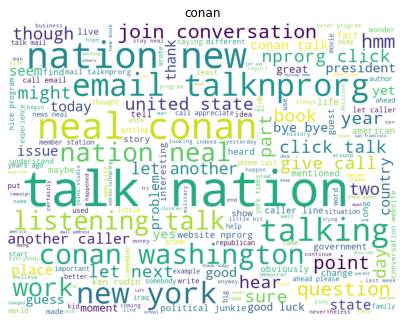

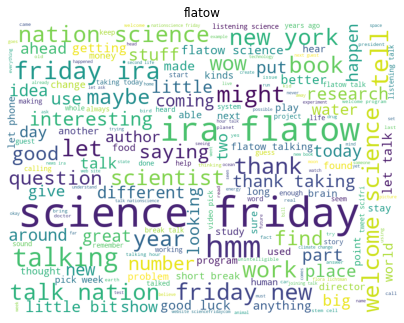

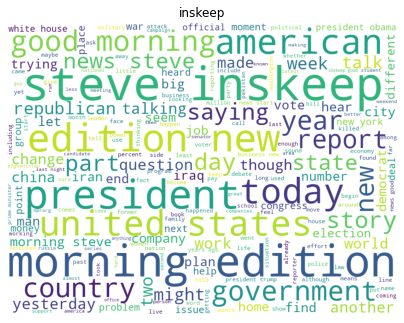

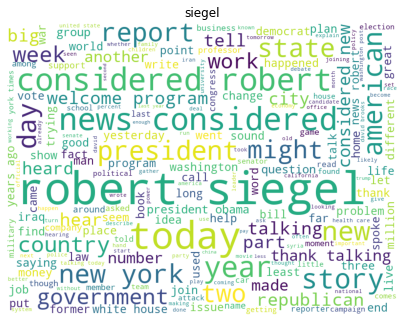

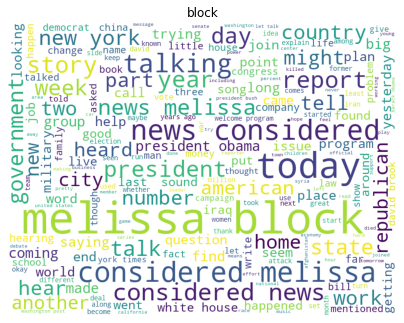

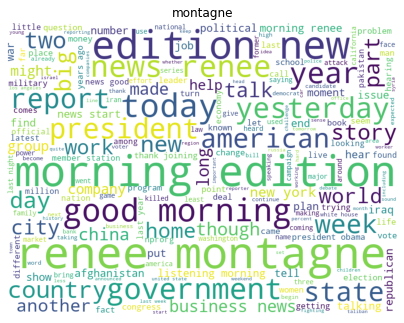

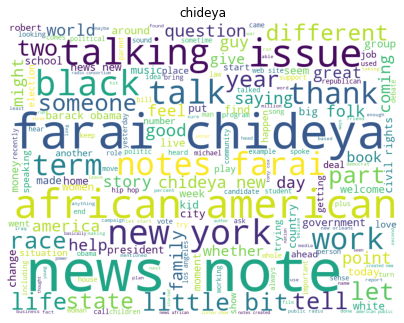

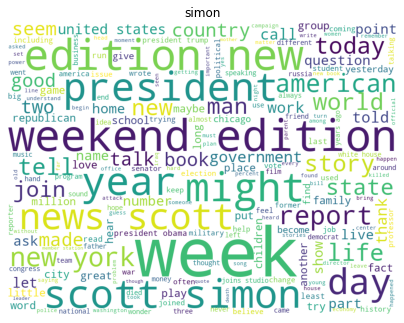

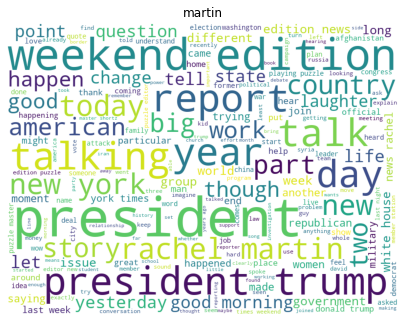

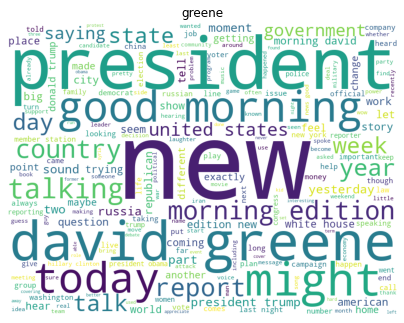

In [88]:
# word clouds
for h in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

In [ ]:
# train['message_length'] = train.clean.apply(len)
# train['word_count'] = train.clean.apply(basic_clean).apply(str.split).apply(len)

# validate['message_length'] = validate.clean.apply(len)
# validate['word_count'] = validate.clean.apply(basic_clean).apply(str.split).apply(len)

# test['message_length'] = test.clean.apply(len)
# test['word_count'] = test.clean.apply(basic_clean).apply(str.split).apply(len)

# train.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,message_length,word_count
161541,118827,37,patti neighmond,...to the second house call.,morning edition,after-hours doctor calls save holland money,False,... to the second house call .,... to the second house call .,0.0000,2008-07-17,30,7
93034,120125,11,scott horsley,"But Vice President Biden, who oversees the pro...",all things considered,"as obama touts stimulus, americans are skeptical",False,"but vice president biden , who oversees the pr...","but vice president biden , who oversees the pr...",0.0000,2010-06-18,130,25
2111715,66141,43,"neal conan, host",They weren't accountable to their children.,talk of the nation,is barack obama the new black role model?,True,they weren t accountable to their children .,they weren t accountable to their child .,0.0000,2009-02-02,44,8
98286,103967,9,"michele kelemen, byline","Neumann was ambassador to many trouble spots, ...",all things considered,ambassadors question decision to close mideast...,False,"neumann was ambassador to many trouble spots ,...","neumann wa ambassador to many trouble spot , i...",-0.5187,2013-08-05,203,36
1406249,122930,19,pam fessler,"He says in 1992, for example, then-Arkansas Go...",morning edition,senators lobby for regional primary system,False,"he says in 1992 , for example , then arkansas ...","he say in 1992 , for example , then arkansas g...",0.8126,2007-09-20,314,55


In [89]:
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').message_length.mean())
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.mean())
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.sum())

speaker
david greene      180.641208
farai chideya     190.247265
ira flatow        122.812125
melissa block     164.804195
neal conan        148.897502
rachel martin     159.288261
renee montagne    170.935861
robert siegel     174.663300
scott simon       181.436066
steve inskeep     169.304454
Name: message_length, dtype: float64
speaker
david greene      35.210716
farai chideya     37.711181
ira flatow        25.501025
melissa block     31.929640
neal conan        30.021321
rachel martin     31.105428
renee montagne    32.481760
robert siegel     33.539500
scott simon       35.171162
steve inskeep     32.483828
Name: word_count, dtype: float64
speaker
david greene       594709
farai chideya      768667
ira flatow        1044879
melissa block      717012
neal conan        4293259
rachel martin      546118
renee montagne     677602
robert siegel      936557
scott simon        663715
steve inskeep     1081679
Name: word_count, dtype: int64


In [91]:
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).message_length.sum()

speaker        story_id_num
david greene   777             1742
               780              189
               800              667
               802              708
               804              489
                               ... 
steve inskeep  133180            18
               133182            23
               133184           453
               135547           365
               138265          1624
Name: message_length, Length: 57101, dtype: int64

In [92]:
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','story_id_num']).word_count.sum()

speaker        story_id_num
david greene   777             335
               780              38
               800             121
               802             141
               804              91
                              ... 
steve inskeep  133180            5
               133182            6
               133184           80
               135547           69
               138265          311
Name: word_count, Length: 57101, dtype: int64

In [ ]:
# train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).word_count.mean()

speaker              episode_id
david greene, host   777           23.928571
                     780           19.000000
                     800           60.500000
                     802           23.500000
                     804           91.000000
                                     ...    
steve inskeep, host  133180         5.000000
                     133182         6.000000
                     133184        26.666667
                     135547        34.500000
                     138265        28.272727
Name: word_count, Length: 56725, dtype: float64

In [94]:
top_words_by_host = {}

for host in word_counts.columns.to_list():
    top_words_by_host[host] = pd.DataFrame(word_counts.sort_values(host, ascending = False).head(20))

In [101]:
top_words_by_host['siegel']

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
robert,1111,163,168,2858,232,130,435,118,108,87
siegel,49,6,1,2660,30,0,1,6,5,3
new,10385,2454,2207,2630,1916,1936,1966,1743,1334,1329
today,10582,1308,1530,2447,1779,1137,916,516,649,785
news,9406,1183,3194,2343,1964,2576,2816,1511,714,1044
president,4833,545,3183,2015,1439,1383,1186,1494,1506,1764
considered,502,28,172,1878,1751,92,83,132,67,79
reports,395,42,1955,1539,1306,1869,82,636,373,657
year,3400,729,1260,1430,899,1011,582,786,601,770
talking,6878,2617,726,1373,823,359,844,244,520,703
